<a href="https://colab.research.google.com/github/SuzanneOngCodes/Semantic-segmentation/blob/main/Adam_%2B_ResNext50_%2B_PSPNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Cited from PSPNet**

In [ ]:
## If there is a problem in running the dataloader, try:
# !pip uninstall albumentations
## Restart runtime and continue
%%capture
!pip install --upgrade albumentations

In [ ]:
## Initial setup - removing redundant directory
## Average time to compute - approx. 1-2 mins
# Comment out %%capture to view downloading progress
%%capture
!rm -rf sample_data/

!pip install --upgrade transformers
!pip install opencv-python-headless==4.5.2.52
# !pip uninstall segmentation_models.pytorch
!pip install segmentation-models-pytorch==0.2.0

In [ ]:
# Comment out %%capture to view downloading progress
%%capture
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW
import torch
import shutil
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import os
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor
import pandas as pd
import cv2 as cv
import numpy as np
import albumentations as album
import tensorflow as tf
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import DataLoader

# Import dataset here. 
**In this project, we will be starting off with RUGD offroad dataset from** http://rugd.vision

In [ ]:
# Comment out %%capture to view downloading progress
%%capture

if os.path.exists("/content/data") == False : 
  !mkdir data
  %cd data

  # Download and unzip raw frames from videos
  !wget http://rugd.vision/data/RUGD_frames-with-annotations.zip
  !unzip RUGD_frames-with-annotations.zip

  # Download and unzip raw annotations
  !wget http://rugd.vision/data/RUGD_annotations.zip
  !unzip RUGD_annotations.zip

  # Remove zip files
  !rm -r RUGD_annotations.zip
  !rm -r RUGD_frames-with-annotations.zip

  %mkdir "RUGD_frames-with-annotations"/training 
  %mkdir "RUGD_frames-with-annotations"/validation
  %mkdir "RUGD_frames-with-annotations"/testing
  %mkdir RUGD_annotations/training 
  %mkdir RUGD_annotations/validation
  %mkdir RUGD_annotations/testing

In [ ]:
id2label = {
    0: 'dirt',
    1: 'sand',
    2: 'grass',
    3: 'tree',
    4: 'pole',
    5: 'water',
    6: 'sky',
    7: 'vehicle',
    8: 'container/generic-object',
    9: 'asphalt',
    10: 'gravel',
    11: 'building',
    12: 'mulch',
    13: 'rock-bed',
    14: 'log',
    15: 'bicycle',
    16: 'person',
    17: 'fence',
    18: 'bush',
    19: 'sign',
    20: 'rock',
    21: 'bridge',
    22: 'concrete', 
    23: 'picnic-table'
 }

id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}

## Check if there are 24 labels
num_labels = len(id2label)
print(num_labels)
CLASSES = ["void","dirt", "sand", "grass", "tree", "pole", "water", "sky", 
        "vehicle", "container/generic-object", "asphalt", "gravel", 
        "building", "mulch", "rock-bed", "log", "bicycle", "person", 
        "fence", "bush", "sign", "rock", "bridge", "concrete", "picnic-table"]

COLORMAP = [ [0,0,0],[ 108, 64, 20 ], [ 255, 229, 204 ],[ 0, 102, 0 ],[ 0, 255, 0 ],
            [ 0, 153, 153 ],[ 0, 128, 255 ],[ 0, 0, 255 ],[ 255, 255, 0 ],[ 255, 0, 127 ],
            [ 64, 64, 64 ],[ 255, 128, 0 ],[ 255, 0, 0 ],[ 153, 76, 0 ],[ 102, 102, 0 ],
            [ 102, 0, 0 ],[ 0, 255, 128 ],[ 204, 153, 255 ],[ 102, 0, 204 ],[ 255, 153, 204 ],
            [ 0, 102, 102 ],[ 153, 204, 255 ],[ 102, 255, 255 ],[ 101, 101, 11 ],[ 114, 85, 47 ] ]

color_id = {tuple(c):i for i, c in enumerate(COLORMAP)}

select_class_indices = [CLASSES.index(cls.lower()) for cls in CLASSES]
select_class_rgb_values =  np.array(COLORMAP)[select_class_indices]

24


In [ ]:
# Helper function to visualize on a sample image 
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map
    
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

# classes for data loading and preprocessing
class SemanticSegmentationDataset():

    def __init__(self, root_dir, train, colormap = select_class_rgb_values, augmentation = None, preprocessing=None):
        
        self.root_dir = root_dir
        self.train = train
        self.colormap = colormap
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.transform = torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

        self.img_dir = os.path.join(self.root_dir, "RUGD_frames-with-annotations")
        self.ann_dir = os.path.join(self.root_dir, "RUGD_annotations")
        
        # read images and allocate them to training, validation and testing sets 
        sub_train = ["creek", "park-1", "park-2", "trail-4", "trail-11","trail-12","trail-13","trail-14", "trail-5", "trail-6"]
        sub_valid = ["trail-7","trail-9", "village"]
        sub_test = ["trail-15", "trail-3", "park-8","trail","trail-10"]

        places = []
        subpath = ""
        if self.train==1:
          places = sub_train
          subpath = "training"
        elif self.train == 2:
          places = sub_test
          subpath = "testing"
        else:
          places = sub_valid
          subpath = "validation"

        image_file_names = [] 
        annotation_file_names = []
        self.img_directory = os.path.join(self.img_dir, subpath)
        self.ann_directory = os.path.join(self.ann_dir, subpath)

        for i in places:
          source_dir = os.path.join(self.img_dir, i)
          source_a_dir = os.path.join(self.ann_dir, i)

          for j in os.listdir(source_dir):
            shutil.copy(os.path.join(source_dir,j), self.img_directory) ## Or shutil.set to save memory

          for j in os.listdir(source_a_dir):
            shutil.copy(os.path.join(source_a_dir,j), self.ann_directory)
          

        ## Make sure that all frames matches with the assigned annotations
        for root, dirs, files in os.walk(self.img_directory):
          image_file_names.extend(files)
          annotation_file_names.extend(files)
          
        self.images = sorted(image_file_names)
        self.annotations = sorted(annotation_file_names)
        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = cv.cvtColor(cv.imread(os.path.join(self.img_directory,self.images[idx])), cv.COLOR_BGR2RGB)
        mask = cv.cvtColor(cv.imread(os.path.join(self.ann_directory,self.annotations[idx])), cv.COLOR_BGR2RGB)
        
        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.colormap).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask

In [ ]:
# Resize width and height
#transform = transforms.Compose([transforms.Resize(64), transforms.ToTensor()])
def get_training_augmentation():
    train_transform = [
        album.Resize(304, 304),
        album.PadIfNeeded(min_height=100, min_width=100, always_apply=True, border_mode=0),
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.5,
        ),
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [
        album.Resize(304, 304),
        album.PadIfNeeded(min_height=100, min_width=100, always_apply=True, border_mode=0),
    ]
    return album.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """   
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)


In [ ]:
train_set = SemanticSegmentationDataset(root_dir="/content/data", train = 1, augmentation = get_training_augmentation())
# test_set = SemanticSegmentationDataset(root_dir="/content/data", train = 2)
val_set = SemanticSegmentationDataset(root_dir="/content/data", train = 3)

In [ ]:
## Length of all sets
print("Number of training examples:", len(train_set))
print("Number of validation examples:", len(val_set))
# print("Number of testing examples:", len(test_set))

Number of training examples: 4968
Number of validation examples: 465


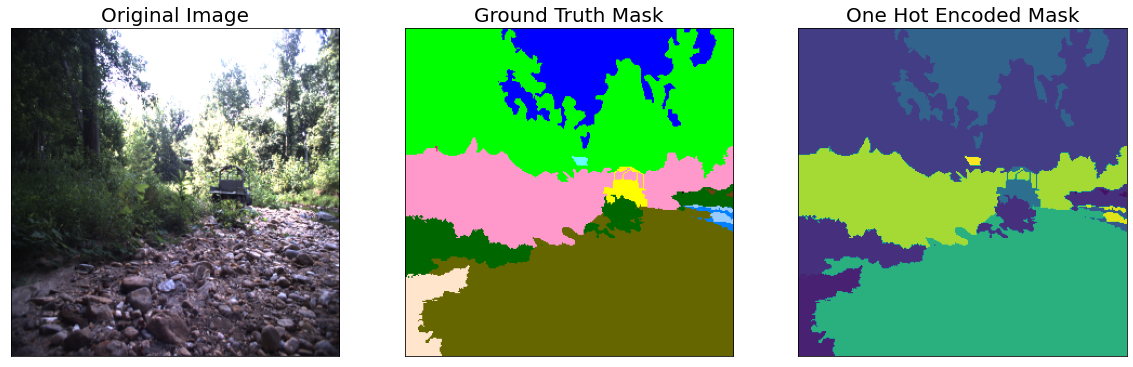

(304, 304)

In [ ]:
# Check format
random_idx = np.random.randint(0, len(train_set)-1)
image, mask = train_set[2]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)
reverse_one_hot(mask).shape

In [ ]:
import segmentation_models_pytorch as smp

ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.PSPNet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
preprocessing_fn

functools.partial(<function preprocess_input at 0x7f8dd08cab00>, input_space='RGB', input_range=[0, 1], mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [ ]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
# !pip uninstall segmentation_models.pytorch
# !pip install segmentation-models-pytorch==0.2.0

TRAINING = True

# Set num of epochs
EPOCHS = 1

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss = smp.utils.losses.DiceLoss()

# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Fscore(threshold=0.5),
    smp.utils.metrics.Accuracy(threshold=0.5),
    smp.utils.metrics.Recall(threshold=0.5),
    smp.utils.metrics.Precision(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

model.to(DEVICE)

# load best saved model checkpoint from previous commit (if present)
if os.path.exists('/content/drive/MyDrive/Colab Notebooks/best_modelPSPAdam.pth'):
    model = torch.load('/content/drive/MyDrive/Colab Notebooks/best_modelPSPAdam.pth', map_location=DEVICE)

# To test ...
o = model(torch.zeros(1,3,504,504).to(DEVICE))
o.shape

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


torch.Size([1, 25, 504, 504])

In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

import albumentations
# Get train and val dataset instances
train_dataset = SemanticSegmentationDataset(
    root_dir='/content/data', 
    augmentation=get_training_augmentation(),
    train = 1,
    preprocessing=get_preprocessing(preprocessing_fn),
)

valid_dataset = SemanticSegmentationDataset(
    root_dir = '/content/data', 
    augmentation=get_validation_augmentation(),
    train=3,
    preprocessing=get_preprocessing(preprocessing_fn),
)

In [ ]:
## Basic DataLoader implementation
# class Dataloader(torch.utils.data.Dataset):
#     def __init__(self):
#         self.images = torch.Tensor(512, 3, 224, 224)

#     def __len__(self):
#         return 512

#     def __getitem__(self, idx):
#         return self.images[idx, :, :, :], torch.ones(1) * 2

# train_data = Dataloader()
# train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, num_workers=2, batch_size=50)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=20, shuffle=False, num_workers=0, pin_memory=True)

In [ ]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_modelPSPAdam.pth')
            print('Model saved!')


Epoch: 0
train:   0%|          | 0/249 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


valid: 100%|██████████| 24/24 [03:27<00:00,  8.63s/it, dice_loss - 0.4619, iou_score - 0.3996, fscore - 0.54, accuracy - 0.9719, recall - 0.6202, precision - 0.517]
Model saved!
CPU times: user 38min 50s, sys: 2min 12s, total: 41min 3s
Wall time: 41min 3s


In [ ]:
# load best saved model checkpoint from the current run
if os.path.exists('/content/best_modelPSPAdam.pth'):
    model = torch.load('/content/best_modelPSPAdam.pth', map_location=DEVICE)
    print('Loaded PSPNet model from this run.')

# load best saved model checkpoint from previous commit (if present)
elif os.path.exists('/content/drive/MyDrive/Colab Notebooks/best_modelPSPAdam.pth'):
    model = torch.load('/content/drive/MyDrive/Colab Notebooks/best_modelPSPAdam.pth', map_location=DEVICE)
    print('Loaded PSPNet model from a previous commit.')

Loaded PSPNet model from a previous commit.


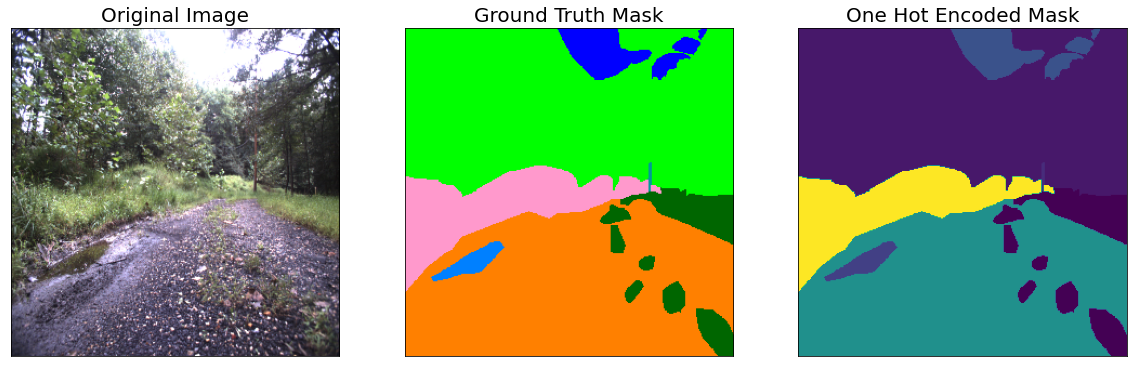

In [ ]:
# create test dataloader (with preprocessing operation: to_tensor(...))
test_dataset = SemanticSegmentationDataset(
    root_dir = "/content/data", 
    augmentation=get_validation_augmentation(), 
    train = 2,
)

# test dataset for visualization (without preprocessing augmentations & transformations)
# get a random test image/mask index
random_idx = np.random.randint(0, len(test_dataset)-1)
image, mask = test_dataset[random_idx]
visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

In [ ]:
preds_folder = '/content/predictionsPSPAdam/'
if not os.path.exists(preds_folder):
    os.makedirs("/content/predictionsPSPAdam/")

In [ ]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

test_dataloader = DataLoader(test_dataset, batch_size=20, shuffle=True, num_workers=0)

test_logs = test_epoch.run(test_dataloader)

test_logs

valid:   1%|          | 1/101 [00:08<14:55,  8.96s/it, dice_loss - 0.1936, iou_score - 0.6792, fscore - 0.809, accuracy - 0.9852, recall - 0.7852, precision - 0.8341]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


valid: 100%|██████████| 101/101 [14:50<00:00,  8.82s/it, dice_loss - 0.1584, iou_score - 0.7322, fscore - 0.8448, accuracy - 0.9879, recall - 0.8214, precision - 0.8698]


{'accuracy': 0.9879419815422282,
 'dice_loss': 0.15839302834897936,
 'fscore': 0.8448267974475824,
 'iou_score': 0.7322020212022388,
 'precision': 0.8697674994421478,
 'recall': 0.8214289906001325}

In [ ]:
test_dataset = SemanticSegmentationDataset(
    root_dir='/content/data', 
    augmentation=get_validation_augmentation(),
    train = 2,
    preprocessing=get_preprocessing(preprocessing_fn),
)

In [ ]:
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {test_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {test_logs['dice_loss']:.4f}")
print(f"Mean F score: {test_logs['dice_loss']:.4f}")
print(f"Mean Accuracy: {test_logs['dice_loss']:.4f}")
print(f"Mean Recall: {test_logs['dice_loss']:.4f}")
print(f"Mean Precision: {test_logs['dice_loss']:.4f}")

Evaluation on Test Data: 
Mean IoU Score: 0.7322
Mean Dice Loss: 0.1584
Mean F score: 0.1584
Mean Accuracy: 0.1584
Mean Recall: 0.1584
Mean Precision: 0.1584


In [ ]:
## For sample illustrations
# Center crop padded image / mask to original image dims
def crop_image(image, true_dimensions):
    return album.CenterCrop(p=1, height=304, width=304)(image=image)

# test dataset for visualization (without preprocessing augmentations & transformations)
test_dataset_vis = SemanticSegmentationDataset(
    root_dir='/content/data',
    augmentation = get_validation_augmentation(),
    train = 2
)

In [ ]:
for idx in range(500):
    image, gt_mask = test_dataset[idx]
    image_vis = test_dataset_vis[idx][0].astype('uint8')
    true_dimensions = image_vis.shape
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    # Predict test image
    pred_mask = model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask,(1,2,0))
    # Get prediction channel corresponding to sky, or any classes available
    pred_foreground_heatmap = crop_image(pred_mask[:,:,CLASSES.index("sky")], true_dimensions)['image']
    pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values), true_dimensions)['image']
    # Convert gt_mask from `CHW` format to `HWC` format
    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = crop_image(colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values), true_dimensions)['image']
    cv.imwrite(os.path.join(preds_folder, f"pred_{idx}.png"), np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])
    #cv.imwrite(os.path.join(preds_folder, f"pred_{idx}.png"), np.hstack([pred_mask])[::-1])

    visualize(
        original_image = image_vis,
        ground_truth_mask = gt_mask,
        predicted_mask = pred_mask,
        pred_foreground_heatmap = pred_foreground_heatmap
    )

In [ ]:
## Copy all info:
with open('inferencePSPAdam.txt', 'w') as convert_file:
  convert_file.write("Training on each epoch")
  convert_file.write(str(train_logs_list))
  convert_file.write("\nTraining means")
  convert_file.write(str(train_logs))
  convert_file.write("\nValid on each epoch")
  convert_file.write(str(valid_logs_list))
  convert_file.write("\nValid means")
  convert_file.write(str(valid_logs))
  convert_file.write("\nTested means")
  convert_file.write(str(test_logs))

In [ ]:
## Download predictions and trained model
!zip -r /content/predictionsPSPAdam.zip /content/predictionsPSPAdam
from google.colab import files
files.download("/content/predictionsPSPAdam.zip")
files.download("/content/data/best_modelPSPAdam.pth")
files.download("/content/data/inferencePSPAdam.txt")

updating: content/predictionsPSPAdam/ (stored 0%)
updating: content/predictionsPSPAdam/pred_19.png (deflated 1%)
updating: content/predictionsPSPAdam/pred_447.png (deflated 1%)
updating: content/predictionsPSPAdam/pred_348.png (deflated 2%)
updating: content/predictionsPSPAdam/pred_197.png (deflated 1%)
updating: content/predictionsPSPAdam/pred_155.png (deflated 1%)
updating: content/predictionsPSPAdam/pred_46.png (deflated 1%)
updating: content/predictionsPSPAdam/pred_398.png (deflated 1%)
updating: content/predictionsPSPAdam/pred_206.png (deflated 1%)
updating: content/predictionsPSPAdam/pred_156.png (deflated 1%)
updating: content/predictionsPSPAdam/pred_458.png (deflated 1%)
updating: content/predictionsPSPAdam/pred_449.png (deflated 1%)
updating: content/predictionsPSPAdam/pred_43.png (deflated 1%)
updating: content/predictionsPSPAdam/sample_pred_68.png (deflated 0%)
updating: content/predictionsPSPAdam/pred_408.png (deflated 1%)
updating: content/predictionsPSPAdam/pred_309.png (

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model

PSPNet(
  (encoder): SENetEncoder(
    (layer0): Sequential(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (layer1): Sequential(
      (0): SEResNeXtBottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (re